In [16]:
# q1
#!/usr/bin/env python
# coding: utf-8

# In[2]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os

print('hello')

def findFiles(path): return glob.glob(path)

#print(findFiles('C:/Users/*.txt'))

# %% 

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

# %%
# Build the names dictionary, a list of names per language
# di tionary keys are languages, values are names
names = {}
languages = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

# PLEASE UPDATE THE FILE PATH BELOW FOR YOUR SYSTEM
for filename in findFiles("names\*.txt"):
    category = os.path.splitext(os.path.basename(filename))[0]
    languages.append(category)
    lines = readLines(filename)
    names[category] = lines

n_categories = len(languages)

def findName(dict, name):
    keys = dict.keys()
    for key in keys:
        if name in dict[key]:
            return key
    return ''

findName(names,'Bernal')
findName(names,'Johnson')


# Now we have ``names``, a dictionary mapping each category
# (language) to a list of lines (names). We also kept track of
# ``languages`` (just a list of languages) and ``n_categories`` for
# later reference.
# 

#print(names['Italian'][:5])

# %% 
# Turning Names into Tensors
# --------------------------
# 
# Now that we have all the names organized, we need to turn them into
# Tensors to make any use of them.
# 
# To represent a single letter, we use a "one-hot vector" of size
# ``<1 x n_letters>``. A one-hot vector is filled with 0s except for a 1
# at index of the current letter, e.g. ``"b" = <0 1 0 0 0 ...>``.
# 
# To make a word we join a bunch of those into a 2D matrix
# ``<line_length x 1 x n_letters>``.
# 
# That extra 1 dimension is because PyTorch assumes everything is in
# batches - we're just using a batch size of 1 here.

import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def nameToTensor(name):
    tensor = torch.zeros(len(name), 1, n_letters)
    for li, letter in enumerate(name):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(nameToTensor('Jones').size())


# %% Creating the Network
# ====================
# 
# Before autograd, creating a recurrent neural network in Torch involved
# cloning the parameters of a layer over several timesteps. The layers
# held hidden state and gradients which are now entirely handled by the
# graph itself. This means you can implement a RNN in a very "pure" way,
# as regular feed-forward layers.
# 
# This RNN module (mostly copied from `the PyTorch for Torch users
# tutorial <https://pytorch.org/tutorials/beginner/former_torchies/
# nn_tutorial.html#example-2-recurrent-net>`__)
# is just 2 linear layers which operate on an input and hidden state, with
# a LogSoftmax layer after the output.
# 
# .. figure:: https://i.imgur.com/Z2xbySO.png
#    :alt:

import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)


def categoryFromOutput(output):
    # compute max
    top_n, top_i = output.topk(1)
    # output index of max
    category_i = top_i.item()
    return languages[category_i], category_i

print(categoryFromOutput(output))

# We will also want a quick way to get a training example (a name and its
# language):
# 
import random

print(languages)

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(languages)
    name = randomChoice(names[category])
    category_tensor = torch.tensor([languages.index(category)], dtype=torch.long)
    name_tensor = nameToTensor(name)
    return category, name, category_tensor, name_tensor

for i in range(10):
    category, name, category_tensor, name_tensor = randomTrainingExample()
    print('category =', category, '/ name =', name)

# %% Training the Network
# --------------------
# 
# Now all it takes to train the network is show it a bunch of examples,
# have it make guesses, and compare its output against labels.
# 
# For the loss function ``nn.NLLLoss`` is appropriate, since the last
# layer of the RNN is ``nn.LogSoftmax``.
# 
criterion = nn.NLLLoss()

# Each loop of training will:
# 
# -  Create input and target tensors
# -  Create a zeroed initial hidden state
# -  Read each letter in and
# 
#    -  Keep hidden state for next letter
# 
# -  Compare final output to target
# -  Back-propagate
# -  Return the output and loss
# 

learning_rate = 0.005 # For this example, we keep the learning rate fixed

def train(category_tensor, name_tensor):
    # initialize hidden state - do this every time before passing an input sequence
    hidden = rnn.initHidden()
    # reset grad counters - do this every time after backprop
    rnn.zero_grad()
    # manually go through each element in input sequence
    for i in range(name_tensor.size()[0]):
        output, hidden = rnn(name_tensor[i], hidden)
    # backpropagate based on loss at last element only
    loss = criterion(output, category_tensor)
    loss.backward()

    # Update network parameters
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item()



hello
Slusarski
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])
('Vietnamese', 17)
['Arabic', 'Chinese', 'Czech', 'Dutch', 'English', 'French', 'German', 'Greek', 'Irish', 'Italian', 'Japanese', 'Korean', 'Polish', 'Portuguese', 'Russian', 'Scottish', 'Spanish', 'Vietnamese']
category = French / name = Sauvage
category = French / name = Glaisyer
category = Irish / name = Mahoney
category = French / name = Leandres
category = Scottish / name = Kennedy
category = Japanese / name = Obinata
category = Spanish / name = Vargas
category = Spanish / name = Reyes
category = Vietnamese / name = Ha
category = Arabic / name = Bazzi


tensor([[-2.9675, -2.9162, -2.8407, -2.7570, -2.9114, -2.9584, -2.8359, -2.8226,
         -2.9714, -2.9993, -2.8355, -2.9688, -2.9007, -2.8341, -2.8780, -3.0524,
         -2.8033, -2.8274]], grad_fn=<LogSoftmaxBackward0>)
5000 5% (0m 5s) 2.1091 Stroggylis / Greek ✓
10000 10% (0m 10s) 2.5296 Guerriero / Portuguese ✗ (Italian)
15000 15% (0m 15s) 1.6342 Rademaker / German ✓
20000 20% (0m 20s) 0.5082 Napoleoni / Italian ✓
25000 25% (0m 26s) 1.3444 Esteves / Portuguese ✓
30000 30% (0m 31s) 0.4048 Anetakis / Greek ✓
35000 35% (0m 36s) 1.3366 Jeon / Korean ✓
40000 40% (0m 41s) 2.0436 Gerald / French ✗ (Irish)
45000 45% (0m 46s) 1.9934 Chou / Korean ✗ (Chinese)
50000 50% (0m 52s) 1.9018 Maria / Spanish ✗ (Portuguese)
55000 55% (0m 57s) 3.1313 Dahl / Japanese ✗ (German)
60000 60% (1m 2s) 1.9330 Schneijder / German ✗ (Dutch)
65000 65% (1m 8s) 0.8979 Kvasnicka / Czech ✓
70000 70% (1m 13s) 0.9028 Pennders / Dutch ✓
75000 75% (1m 18s) 1.5929 Cavey / French ✓
80000 80% (1m 24s) 1.0871 Geroux / Frenc

C:\Users\JkL\AppData\Local\Temp\ipykernel_24592\363008827.py:158: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + languages, rotation=90)
C:\Users\JkL\AppData\Local\Temp\ipykernel_24592\363008827.py:159: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + languages)


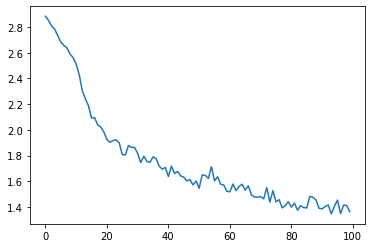

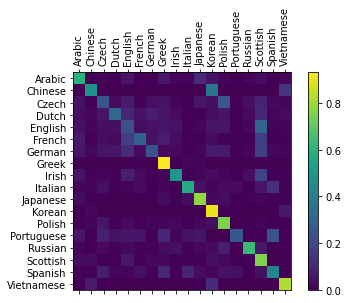


> Dostoevsky
(-1.02) Russian
(-1.27) Czech
(-1.28) Polish

> Jackson
(-0.31) Scottish
(-2.04) English
(-3.07) Russian

> Satoshi
(-1.44) Japanese
(-1.52) Polish
(-1.81) Arabic

> Bernal
(-0.67) Czech
(-2.13) Arabic
(-2.40) German


In [21]:
# Now we just have to run that with a bunch of examples. Since the
# ``train`` function returns both the output and loss we can print its
# guesses and also keep track of loss for plotting. Since there are 1000s
# of examples we print only every ``print_every`` examples, and take an
# average of the loss.
# 
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000

# Keep track of loss for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

#n_hidden = 128
n_hidden = 32
rnn = RNN(n_letters, n_hidden, n_categories)

# %% To run a step of this network we need to pass an input (in our case, the
# Tensor for the current letter) and a previous hidden state (which we
# initialize as zeros at first). We'll get back the output (probability of
# each language) and a next hidden state (which we keep for the next
# step).

input = letterToTensor('A')
hidden = torch.zeros(1, n_hidden)
output, next_hidden = rnn(input, hidden)

# For the sake of efficiency we don't want to be creating a new Tensor for
# every step, so we will use ``nameToTensor`` instead of
# ``letterToTensor`` and use slices. This could be further optimized by
# pre-computing batches of Tensors.
# 

input = nameToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

# As you can see the output is a ``<1 x n_categories>`` Tensor, where
# every item is the likelihood of that category (higher is more likely).
# 

# %% Training
# ========
# Preparing for Training
# ----------------------
# 
# Before going into training we should make a few helper functions. The
# first is to interpret the output of the network, which we know to be a
# likelihood of each category. We can use ``Tensor.topk`` to get the index
# of the greatest value:
# 


for iter in range(1, n_iters + 1):
    category, name, category_tensor, name_tensor = randomTrainingExample()
    output, loss = train(category_tensor, name_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, name, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0


# Plotting the Results
# --------------------
# 
# Plotting the historical loss from ``all_losses`` shows the network
# learning:
#

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)


# Evaluating the Results
# ======================
# 
# To see how well the network performs on different categories, we will
# create a confusion matrix, indicating for every actual language (rows)
# which language the network guesses (columns). To calculate the confusion
# matrix a bunch of samples are run through the network with
# ``evaluate()``, which is the same as ``train()`` minus the backprop.
# 

# In[14]:

# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 20000

# return an output given an input name
def evaluate(name_tensor):
    hidden = rnn.initHidden()

    for i in range(name_tensor.size()[0]):
        output, hidden = rnn(name_tensor[i], hidden)

    return output


def NOTrandomTrainingExample(j,k):
    category = languages[j]
    name = names[category][k]
    category_tensor = torch.tensor([languages.index(category)], dtype=torch.long)
    name_tensor = nameToTensor(name)
    return category, name, category_tensor, name_tensor

# Go through a bunch of examples and record which are correctly guessed

for j in range(len(languages)):
    category = languages[j]
    for k in range(len(names[category])):
        category, name, category_tensor, name_tensor = NOTrandomTrainingExample(j,k)
        output = evaluate(name_tensor)
        guess, guess_i = categoryFromOutput(output)
        category_i = languages.index(category)
        confusion[category_i][guess_i] += 1
    
accuracy = sum(confusion.diag())/sum(sum(confusion))
print('Accuracy is %f' % accuracy.item())

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + languages, rotation=90)
ax.set_yticklabels([''] + languages)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

 
#You can pick out bright spots off the main axis that show which
# languages it guesses incorrectly, e.g. Chinese for Korean, and Spanish
# for Italian. It seems to do very well with Greek, and very poorly with
# English (perhaps because of overlap with other languages).
# 

# CODE below is for illustration only
# Running on User Input
# ---------------------
# 

# In[15]:

def predict(name, n_predictions=3):
    print('\n> %s' % name)
    with torch.no_grad():
        output = evaluate(nameToTensor(name))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, languages[category_index]))
            predictions.append([value, languages[category_index]])

findName(names,'Dostoevsky')
predict('Dostoevsky')
findName(names,'Jackson')
predict('Jackson')
findName(names,'Satoshi')
predict('Satoshi')
predict('Bernal')
